In [1]:
from attacksplitnn.splitnn import Client, Server, SplitNN
from attacksplitnn.attack import Black_Box_Model_Inversion
from attacksplitnn.utils import DataSet

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
config = {
    "batch_size":128
}

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.random.manual_seed(42)
print(device)

cpu


In [5]:
transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [7]:
victim_idx = random.sample(range(trainset.data.shape[0]), k=2000)
victim_train_idx = victim_idx[:1000]
attack_idx = victim_idx[1000:]
victim_test_idx = random.sample(range(testset.data.shape[0]), k=15)

In [8]:
victim_train_dataset = Subset(trainset, victim_train_idx)
attack_dataset = Subset(trainset, attack_idx)
victim_test_dataset = Subset(testset, victim_test_idx)

In [9]:
victim_train_dataloader = torch.utils.data.DataLoader(victim_train_dataset, batch_size=64, shuffle=True)
attack_dataloader = torch.utils.data.DataLoader(attack_dataset, batch_size=64, shuffle=True)
victim_test_dataloader = torch.utils.data.DataLoader(victim_test_dataset, batch_size=64, shuffle=False)

In [10]:
class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
                               kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x) # [64,32,32]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x) # [128,16,16]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        return x

In [11]:
# CNNを実装する
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(512, 10) # 10クラス分類

    def forward(self, x):
        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x) # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x) # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]
        # 全結合層
        x = x.view(-1, 512)
        x = self.L1(x)
        #x = F.softmax(x, dim=0)
        return x


## Train victim SplitNN

In [12]:
model_1 = FirstNet()
model_1 = model_1.to(device)

model_2 = SecondNet()
model_2 = model_2.to(device)

opt_1 = optim.Adam(model_1.parameters(), lr=1e-3)
opt_2 = optim.Adam(model_2.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [13]:
def accuracy(label, output):
    pred = output.argmax(dim=1, keepdim=True)
    return pred.eq(label.view_as(pred)).sum().item() / pred.shape[0]

In [14]:
client = Client(model_1, opt_1)
server = Server(model_2, opt_2, criterion)

sn = SplitNN(client, server, device=device)
sn.fit(victim_train_dataloader , 3, metric=accuracy)

epoch 1, loss 0.018916, metric 0.651
epoch 2, loss 0.003491, metric 0.95
epoch 3, loss 0.0012885, metric 0.981


## Train Attacker

In [15]:
# CNNを実装する
class Attacker(nn.Module):
    def __init__(self):
        super(Attacker, self).__init__()
        self.fla = nn.Flatten()
        self.ln1 = nn.Linear(128*7*7, 1000)
        self.ln2 = nn.Linear(1000, 784)

    def forward(self, x):
        x = self.fla(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.ln2(x)
        x = x.view(-1, 1, 28, 28)

        return x
    
attacker = Attacker()
attacker = attacker.to(device)

opt_3 = optim.Adam(attacker.parameters(), lr=1e-3)

In [16]:
bbmi = Black_Box_Model_Inversion(sn, attacker, opt_3)
bbmi.fit(attack_dataloader, 15)

epoch 0: reconstruction_loss 0.7462722063064575
epoch 1: reconstruction_loss 0.6261448264122009
epoch 2: reconstruction_loss 0.4733526110649109
epoch 3: reconstruction_loss 0.39553147554397583
epoch 4: reconstruction_loss 0.38866063952445984
epoch 5: reconstruction_loss 0.3257603049278259
epoch 6: reconstruction_loss 0.34410879015922546
epoch 7: reconstruction_loss 0.31412816047668457
epoch 8: reconstruction_loss 0.2879074513912201
epoch 9: reconstruction_loss 0.28160426020622253
epoch 10: reconstruction_loss 0.2965676784515381
epoch 11: reconstruction_loss 0.25125348567962646
epoch 12: reconstruction_loss 0.24539747834205627
epoch 13: reconstruction_loss 0.23604340851306915
epoch 14: reconstruction_loss 0.22705817222595215


In [17]:
attack_result = bbmi.attack(victim_test_dataloader)
attack_result = attack_result.detach().numpy()

## Attack Result

### Private data

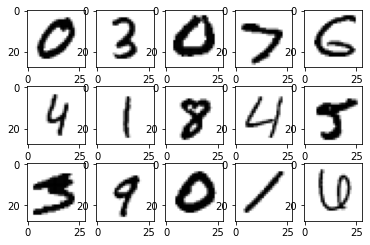

In [18]:
for data, _ in victim_test_dataloader:
    break
    
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(data[i-1].reshape(28,28),cmap='gray_r')

plt.show()

### Reconstructed data

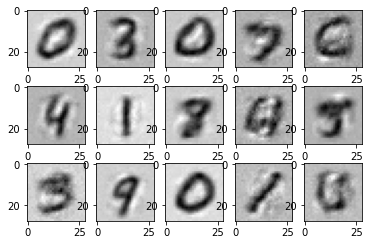

In [19]:
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(attack_result[i-1].reshape(28,28),cmap='gray_r')
#plt.title("reconstructed data")
plt.show()